In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# đánh giá dữ liệu

In [3]:
trd = pd.read_csv('train.csv')
tsd = pd.read_csv('test.csv')
td = pd.concat([trd, tsd], ignore_index=True, sort  = False)

giá trị bị thiếu

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

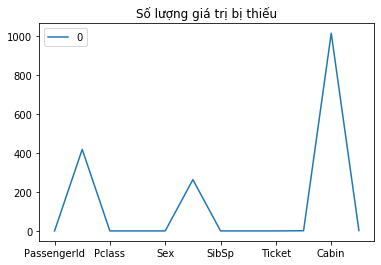

In [4]:
pd.DataFrame(td.isnull().sum()).plot.line().set_title("Số lượng giá trị bị thiếu")
td.isnull().sum()

# Survived :
Ta có thể thấy được hơn 60 % những người trên thuyền là bị chết


Text(0.5, 1.0, 'phần trăm số người được cứ sống và chết (tập traning)')

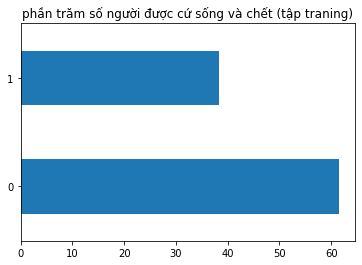

In [5]:
(trd.Survived.value_counts(normalize=True) * 100).plot.barh().set_title("phần trăm số người được cứ sống và chết (tập traning)")

# Pclass

Đa số hành khách là những người đi khoang hạng 3 (khoang giá bình dân)

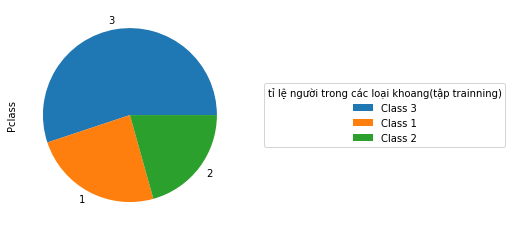

In [6]:
fig_pclass = trd.Pclass.value_counts().plot.pie().legend(labels=["Class 3","Class 1","Class 2"], loc='center right', bbox_to_anchor=(2.25, 0.5)).set_title("tỉ lệ người trong các loại khoang(tập trainning)")


Có thể thấy rõ ràng những người ở khoang hạng 1 có tỉ lể được cứu sống cao hơn rất nhiều so với các khoang hạng khác . từ đó rút ra được rằng những người nhiều tiền hoặc có địa vị sẽ có tỉ lệ sống cao hơn

Text(0.5, 1.0, 'Phần trăm người được cứu trong các loại khoang')

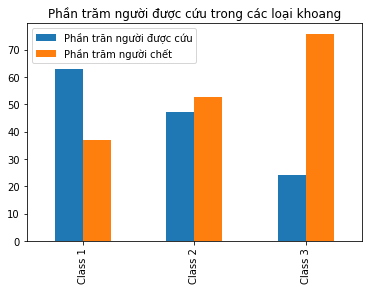

In [7]:
pclass_1_survivor_distribution = round((trd[trd.Pclass == 1].Survived == 1).value_counts()[1]/len(trd[trd.Pclass == 1]) * 100, 2)
pclass_2_survivor_distribution = round((trd[trd.Pclass == 2].Survived == 1).value_counts()[1]/len(trd[trd.Pclass == 2]) * 100, 2)
pclass_3_survivor_distribution = round((trd[trd.Pclass == 3].Survived == 1).value_counts()[1]/len(trd[trd.Pclass == 3]) * 100, 2)
pclass_perc_df = pd.DataFrame(
    { "Phần trăn người được cứu":{"Class 1": pclass_1_survivor_distribution,"Class 2": pclass_2_survivor_distribution, "Class 3": pclass_3_survivor_distribution},  
     "Phần trăm người chết":{"Class 1": 100-pclass_1_survivor_distribution,"Class 2": 100-pclass_2_survivor_distribution, "Class 3": 100-pclass_3_survivor_distribution}})
pclass_perc_df.plot.bar().set_title("Phần trăm người được cứu trong các loại khoang")



# Embarked:
Số lượng hành khách lên tàu từ Southampton là nhiều nhất nhưng tỉ lệ người được cứu sống nhiều nhất lại là đến từ Cherboug Embarked


Text(0.5, 1.0, 'số lượng người được cứu sống và chết dựa trên địa điểm họ lên tàu.')

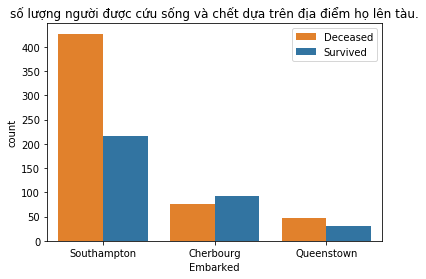

In [8]:
p = sns.countplot(x = "Embarked", hue = "Survived", data = trd, palette=["C1", "C0"])
p.set_xticklabels(["Southampton","Cherbourg","Queenstown"])
p.legend(labels = ["Deceased", "Survived"])
p.set_title("số lượng người được cứu sống và chết dựa trên địa điểm họ lên tàu.")

# Sử dụng thuật toán phân lớp

In [9]:
td['Age_Range'] = pd.cut(td.Age, [0, 10, 20, 30, 40, 50, 60,70,80])

In [10]:
td["Age_Range"]

0       (20.0, 30.0]
1       (30.0, 40.0]
2       (20.0, 30.0]
3       (30.0, 40.0]
4       (30.0, 40.0]
            ...     
1304             NaN
1305    (30.0, 40.0]
1306    (30.0, 40.0]
1307             NaN
1308             NaN
Name: Age_Range, Length: 1309, dtype: category
Categories (8, interval[int64]): [(0, 10] < (10, 20] < (20, 30] < (30, 40] < (40, 50] < (50, 60] < (60, 70] < (70, 80]]

In [11]:
td['Fare_Category'] = pd.cut(td['Fare'], bins=[0,7.90,14.45,31.28,120], labels=['Low','Mid',
                                                                                      'High_Mid','High'])
td['Fare_Category']


0            Low
1           High
2            Mid
3           High
4            Mid
          ...   
1304         Mid
1305        High
1306         Low
1307         Mid
1308    High_Mid
Name: Fare_Category, Length: 1309, dtype: category
Categories (4, object): [Low < Mid < High_Mid < High]

In [12]:
td['Family'] = td.Parch + td.SibSp
td['Is_Alone'] = td.Family == 0

In [13]:
td['Family']

0       1
1       1
2       0
3       1
4       0
       ..
1304    0
1305    0
1306    0
1307    0
1308    2
Name: Family, Length: 1309, dtype: int64

# Data input

điền các thong tin bị thiếu vào các thuộc tính embarked với giá trị là giá trị phổ biến nhất

In [14]:
td.Embarked.fillna(td.Embarked.mode()[0], inplace = True)

lấy ra cách xưng hô của mọi người từ tên của họ

In [15]:
td['Salutation'] = td.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip()) 
td.Salutation.value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Major             2
Mlle              2
Ms                2
Mme               1
Don               1
the Countess      1
Sir               1
Dona              1
Jonkheer          1
Capt              1
Lady              1
Name: Salutation, dtype: int64

điền các trường dữ liệu còm thiếu của thuộc tính age dựa trên tuổi và hạng khoang tàu họ lên

In [16]:
grp = td.groupby(['Sex', 'Pclass'])  
td.Age = grp.Age.apply(lambda x: x.fillna(x.median()))

td.Age.fillna(td.Age.median, inplace = True)

điền giá trị NA vào các trường còn thiếu của Cabin

In [17]:
td.Cabin = td.Cabin.fillna('NA')

In [18]:
td.Cabin

0         NA
1        C85
2         NA
3       C123
4         NA
        ... 
1304      NA
1305    C105
1306      NA
1307      NA
1308      NA
Name: Cabin, Length: 1309, dtype: object

# Mã Hóa và xóa các cột

In [19]:
td = pd.concat([td,pd.get_dummies(td.Cabin, prefix="Cabin"),pd.get_dummies(td.Age_Range, prefix="Age_Range"), pd.get_dummies(td.Embarked, prefix="Emb", drop_first = True), pd.get_dummies(td.Salutation, prefix="Title", drop_first = True),pd.get_dummies(td.Fare_Category, prefix="Fare", drop_first = True), pd.get_dummies(td.Pclass, prefix="Class", drop_first = True)], axis=1)
td['Sex'] = LabelEncoder().fit_transform(td['Sex'])
td['Is_Alone'] = LabelEncoder().fit_transform(td['Is_Alone'])

In [20]:
td.drop(['Pclass', 'Fare','Cabin', 'Fare_Category','Name','Salutation', 'Ticket','Embarked', 'Age_Range', 'SibSp', 'Parch', 'Age'], axis=1, inplace=True)

NB Accuracy: 56.98%
The cross validated score for GNB is: 67.85


Text(0.5, 1.05, 'Confusion_matrix for NB')

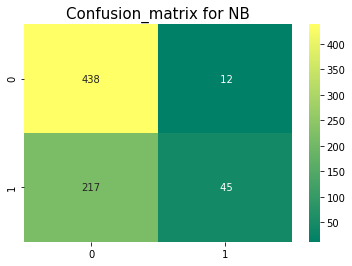

In [21]:
X_to_be_predicted = td[td.Survived.isnull()]
X_to_be_predicted = X_to_be_predicted.drop(['Survived'], axis = 1)

train_data = td
train_data = train_data.dropna()
feature_train = train_data['Survived']
label_train  = train_data.drop(['Survived'], axis = 1)
train_data.shape #891 x 28

##Gaussian
clf = GaussianNB()
x_train, x_test, y_train, y_test = train_test_split(label_train, feature_train, test_size=0.2)
clf.fit(x_train,  np.ravel(y_train))
print("NB Accuracy: "+repr(round(clf.score(x_test, y_test) * 100, 2)) + "%")
result_rf=cross_val_score(clf,x_train,y_train,cv=10,scoring='accuracy')
print('The cross validated score for GNB is:',round(result_rf.mean()*100,2))
y_pred = cross_val_predict(clf,x_train,y_train,cv=10)
sns.heatmap(confusion_matrix(y_train,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix for NB', y=1.05, size=15)

RF Accuracy: 84.36%
The cross validated score for Random forest is: 82.59


Text(0.5, 1.05, 'Confusion_matrix for RF')

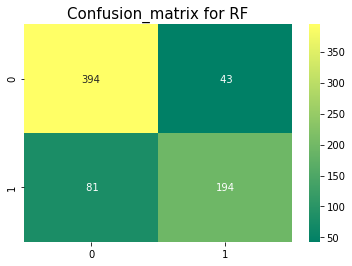

In [22]:
##Random forest
clf = RandomForestClassifier(criterion='entropy', 
                             n_estimators=700,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)
x_train, x_test, y_train, y_test = train_test_split(label_train, feature_train, test_size=0.2)
clf.fit(x_train,  np.ravel(y_train))
print("RF Accuracy: "+repr(round(clf.score(x_test, y_test) * 100, 2)) + "%")

result_rf=cross_val_score(clf,x_train,y_train,cv=10,scoring='accuracy')
print('The cross validated score for Random forest is:',round(result_rf.mean()*100,2))
y_pred = cross_val_predict(clf,x_train,y_train,cv=10)
sns.heatmap(confusion_matrix(y_train,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix for RF', y=1.05, size=15)

# Qua 2 thuật toán thấy Random Forest cho được tỉ lệ chính xác hơn với khoảng 80% trong khi đó Gaussian Naive Bayes chỉ là hơn 60%